# Transfer Learning - MNIST Data Set

## Overview

This notebook illustrates transfer learning using TensorFlow with the Keras API for specifing the CNN architecture.

Structure of the notebook:
* Obtain the MNIST data set
* Split the MNIST data set into even digit data set and odd digit data set
* Prepare image data for modeling, one-hot encode the digit label
* Define feature detection and classification layers for the CNN model
* Train even digit CNN model to recognize even digits and save model structure to disk
* Evaluate model performance against even and odd digit test data sets
* Create odd digit CNN model structure from the even digit model CNN
* Freeze feature detection layers of the odd digit CNN model
* Train CNN model with frozen feature detection layer to recognize odd digits
* Evaluate model performance against odd and even test data sets

## Setup

In [1]:
# configuration and profiling
import time
import os

# set up backend theano or tensorflow
os.environ['KERAS_BACKEND'] = 'tensorflow'


In [2]:
import tensorflow as tf
from tensorflow.python.framework import ops

# TF specific Keras 
from keras import backend as K
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('tf')

import numpy as np

Using TensorFlow backend.


## Obtain MNIST Data Set

In [3]:
from keras.datasets import mnist

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Create even/odd data sets

In [4]:
# split into odd and evens
odds = [i for i,j in enumerate(y_train) if j % 2 == 1 ]
evens = list(set(range(len(y_train))) - set(odds))

X_train_odd = X_train[odds]
y_train_odd = y_train[odds]

X_train_even = X_train[evens]
y_train_even = y_train[evens]

# split into odd and evens
odds = [i for i,j in enumerate(y_test) if j % 2 == 1 ]
evens = list(set(range(len(y_test))) - set(odds))

X_test_odd = X_test[odds]
y_test_odd = y_test[odds]

X_test_even = X_test[evens]
y_test_even = y_test[evens]

## Prepare data for modeling

In [5]:
###
# function to prepare data for modeling
###
def prepareFeatureSet(X_in,y_in):
    # reshape to be [samples][channels][width][height]
    X_out = X_in.reshape(X_in.shape[0], 28, 28, 1).astype('float32')

    # normalize inputs from 0-255 to 0-1
    X_out = X_out / 255
    
    #one-hot encode target variable
    min_y = min(y_in)
    num_classes = len(np.unique(y_in))
    y_out = np_utils.to_categorical((y_in-min_y)/2,num_classes)
    
    return((X_out,y_out))
    

In [6]:
###
# Prepare data for modeling
###
X_train_even_mdl, y_train_even_mdl = prepareFeatureSet(X_train_even,y_train_even)
X_test_even_mdl, y_test_even_mdl = prepareFeatureSet(X_test_even, y_test_even)

X_train_odd_mdl, y_train_odd_mdl = prepareFeatureSet(X_train_odd,y_train_odd)
X_test_odd_mdl, y_test_odd_mdl = prepareFeatureSet(X_test_odd, y_test_odd)

## Plot sample images

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def plotDigitGrid(X,y,idxs,y_hat=None):
    plt.figure(figsize=(12,10))

    for i in range(len(idxs)):
        plt.subplot(5,6,i+1)
        
        if y_hat is None:
            plt.title('Label: {label}'.format(label=y[idxs[i]]))
        else:
            plt.title("Label: {label}  Pred: {pred}".format(label=y[idxs[i]], pred=y_hat[idxs[i]]))
            
        plt.imshow(X[idxs[i]], cmap='Greys')
        plt.tick_params(
            axis='both',          # changes apply to the x-axis and y-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # tick marks on bottom side are off
            left='off',        # tick marks on left side are off
            labelleft='off',   # label on left side are off
            labelbottom='off') # labels along the bottom edge are off

    plt.show()


## Plot Sample Even Digits

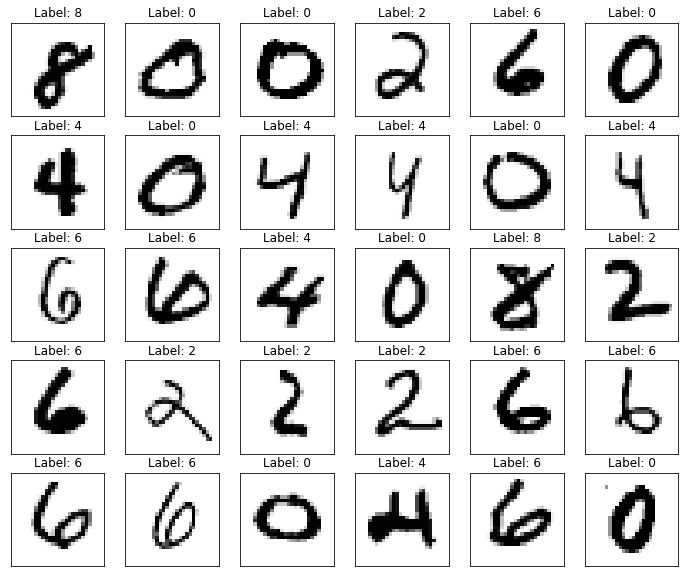

In [8]:
np.random.seed(127)
idxs_even = np.random.choice(y_test_even.shape[0],30)

plotDigitGrid(X_test_even,y_test_even,idxs_even)

## Plot Sample Odd Digits

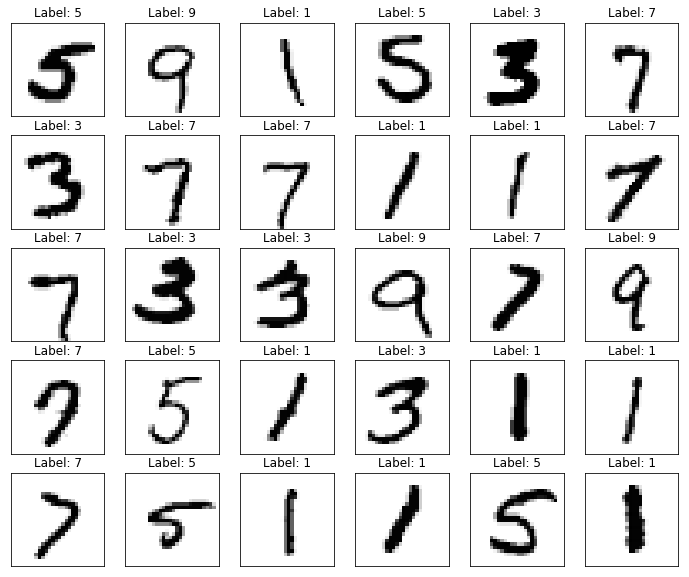

In [9]:
np.random.seed(127)
idxs_odd = np.random.choice(y_test_odd.shape[0],30)

plotDigitGrid(X_test_odd,y_test_odd,idxs_odd)

## Set up for model training

In [10]:
###
# function to train model
###
def train_model(model, x_train, y_train, x_test, y_test):
    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    t = time.time()
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1,
              validation_data=(x_test, y_test))
    print('Training time: %.3f (sec)' % (time.time() - t))


In [11]:
# reset computational TF compuationatl graph
ops.reset_default_graph()

# setup session for the even digit model
sess_even = tf.Session()

# connect Keras to TF
K.set_session(sess_even)



## Define CNN Model architecture

In [12]:
###
# Initialize placeholders
###

# training image data
x_data = tf.placeholder(shape=[None, X_train_even_mdl.shape[1],X_train_even_mdl.shape[2],1], 
                        dtype=tf.float32,
                        name='x_data')

# training image category 
y_target = tf.placeholder(shape=[None, y_train_even_mdl.shape[1]], 
                          dtype=tf.float32,
                         name='y_target')

In [13]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D

###
# Declare model operations
###

x = Convolution2D(30,5,padding='valid',activation='relu',name='ConvLayer1')(x_data)
x = Convolution2D(15,5,activation='relu', name='ConvLayer2')(x)
x = MaxPooling2D(pool_size=(2,2), name='MaxPoolLayer1')(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128,activation='relu',name='DenseLayer1')(x)
x = Dropout(0.5)(x)
y_prob = Dense(5,activation='softmax',name='DenseLayer2')(x)
print(str(type(y_prob)) + str(y_prob.get_shape()))


<class 'tensorflow.python.framework.ops.Tensor'>(?, 5)


In [14]:
###
# Declare Loss Function (softmax cross entropy)
###
from keras.objectives import categorical_crossentropy

loss = tf.reduce_mean(categorical_crossentropy(y_target,y_prob))

# optimize the loss - initial training
train_step = tf.train.AdamOptimizer(name='train_step').minimize(loss)

# optimizae the loss - transfer learning - classification layers only
trainable_layers = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='DenseLayer')
train_step_transfer = tf.train.AdamOptimizer(name='train_step_transfer').minimize(loss,var_list=trainable_layers)
    

## Global parameters for training

In [15]:
BATCH_SIZE = 128

EPOCHS = 5

# ensure TF reproducibiliy
seed = 13
np.random.seed(13)
tf.set_random_seed(seed)

## Train Even Digit Model

In [16]:
###
# function to generate indices for mini-batches for training
###

def generate_mini_batch_indices(X,batch_size=5):
    
    # randomly shuffle the indicies
    idx = np.asarray(range(X.shape[0]))
    np.random.shuffle(idx)

    # determine number of batches to generate
    if len(idx) % batch_size == 0:
        number_batches = len(idx) // batch_size 
    else:
        # account for the last bit of data
        number_batches = len(idx) // batch_size  + 1
        
    # extract indicies for each mini-batch
    index_list = np.array_split(idx,number_batches)
        
    return(index_list)

In [17]:
start_time = time.time()
# Initialize variables
init = tf.global_variables_initializer()
sess_even.run(init)

# Training loop
test_loss = []
for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    
    # generate indices for mini_batches
    batch_idx = generate_mini_batch_indices(X_train_even_mdl,BATCH_SIZE)
    
    # process each mini-batch
    for i in range(len(batch_idx)):
        rand_index = batch_idx[i]
        rand_x = X_train_even_mdl[rand_index]
        rand_y = y_train_even_mdl[rand_index]
        for j in range(1):
            sess_even.run(train_step, feed_dict={x_data: rand_x, 
                                            y_target: rand_y,
                                            K.learning_phase(): 1})

    test_loss = loss.eval(session=sess_even,feed_dict={x_data: X_test_even_mdl, 
                                  y_target: y_test_even_mdl,
                                  K.learning_phase():0})
    print('Epoch: %d, Epoch time: %.1f, Loss: %.5f' % (epoch+1, time.time() - epoch_start_time, test_loss))
    
print('\n\nTraining time: %.3f (sec)' % (time.time()-start_time))

Epoch: 1, Epoch time: 14.4, Loss: 0.03005
Epoch: 2, Epoch time: 11.9, Loss: 0.02315
Epoch: 3, Epoch time: 11.8, Loss: 0.01869
Epoch: 4, Epoch time: 11.8, Loss: 0.01454
Epoch: 5, Epoch time: 11.8, Loss: 0.01487


Training time: 62.162 (sec)


## Save Even Digit Model

In [18]:
###
# save model to disk
###
#Create a saver object which will save all the variables
saver = tf.train.Saver()

saver.save(sess_even, './even_digit_model_tf_keras')

'./even_digit_model_tf_keras'

## Even Digit Model - Evaluate Model on Even Digit Test Data Set

In [19]:
# function to return model performance
def getPerformanceMetrics(sess,X,y):
    yhat = y_prob.eval(session=sess,feed_dict={x_data:X, K.learning_phase():0})
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(yhat,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    accuracy_value = accuracy.eval(session=sess,feed_dict={x_data: X,
                                                          K.learning_phase():0})
    
    loss_value = loss.eval(session=sess,feed_dict={x_data: X, 
                                  y_target: y,
                                  K.learning_phase():0})
    
    return({'accuracy': accuracy_value, 'loss': loss_value})
    

In [20]:
score = getPerformanceMetrics(sess_even,X_test_even_mdl,y_test_even_mdl)
print('\nTest Loss:', score['loss'])
print('Test accuracy:', score['accuracy'])


Test Loss: 0.0148693
Test accuracy: 0.994925


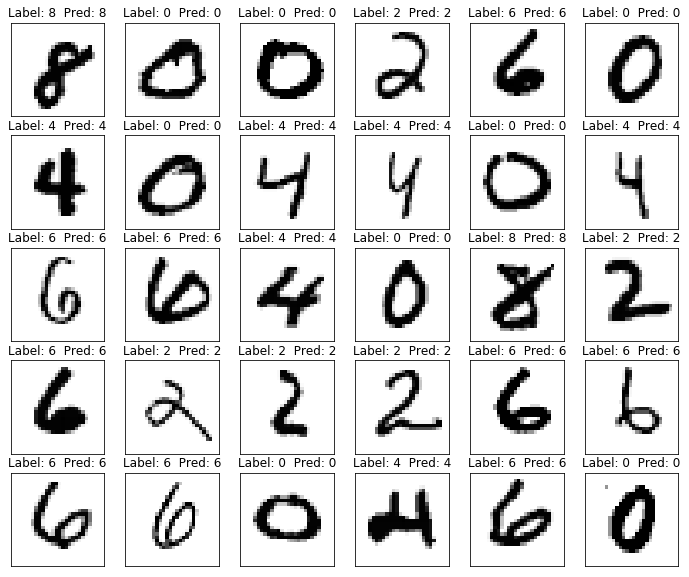

In [21]:
y_hat = np.argmax(y_prob.eval(session=sess_even,feed_dict={x_data:X_test_even_mdl, K.learning_phase():0}),1)

plotDigitGrid(X_test_even,y_test_even,idxs_even,y_hat=2*y_hat)

## Even Digit Model - Evaluate Model on Odd Digit Test Data Set

In [22]:
score = getPerformanceMetrics(sess_even,X_test_odd_mdl,y_test_odd_mdl)
print('\nTest Loss:', score['loss'])
print('Test accuracy:', score['accuracy'])


Test Loss: 8.06109
Test accuracy: 0.0884903


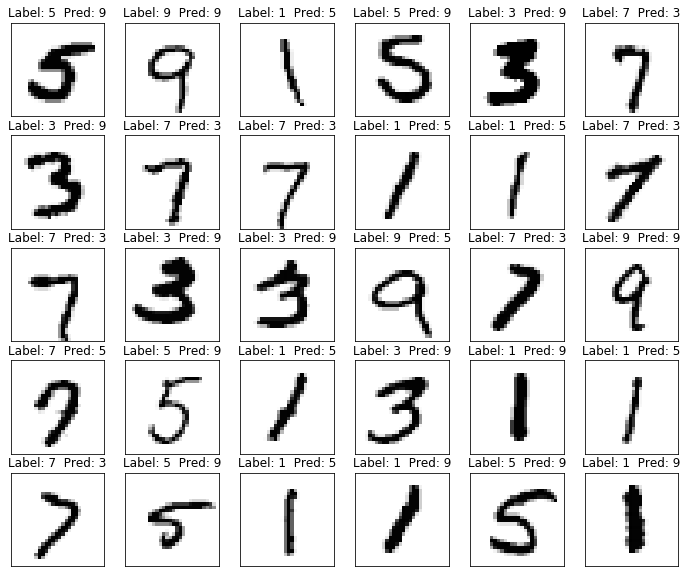

In [23]:
y_hat = np.argmax(y_prob.eval(session=sess_even,feed_dict={x_data:X_test_odd_mdl, K.learning_phase():0}),1)

plotDigitGrid(X_test_odd,y_test_odd,idxs_even,y_hat=2*y_hat+1)

## Transfer Learning
## Initialize Odd Digit Model from Even Digit Model

In [33]:
###
# recerate model structure
###

# reset computational TF compuationatl graph
ops.reset_default_graph()

# set up session for odd digit model
sess_odd=tf.Session()    

# connect Keras to TF
K.set_session(sess_odd)

In [34]:
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('even_digit_model_tf_keras.meta')
saver.restore(sess_odd,tf.train.latest_checkpoint('./'))
sess_odd.run(tf.global_variables_initializer())

## Report Structure on Odd Digit Model Structure

In [56]:
for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
    print(v.name)

ConvLayer1/kernel:0
ConvLayer1/bias:0
ConvLayer2/kernel:0
ConvLayer2/bias:0
DenseLayer1/kernel:0
DenseLayer1/bias:0
DenseLayer2/kernel:0
DenseLayer2/bias:0


In [54]:
for v in tf.get_collection(tf.GraphKeys.TRAIN_OP):
    print(v.name)

train_step
train_step_transfer


In [55]:
trainable_layers = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='DenseLayer')
for v in trainable_layers:
    print(v.name)

DenseLayer1/kernel:0
DenseLayer1/bias:0
DenseLayer2/kernel:0
DenseLayer2/bias:0


In [51]:
for v in tf.get_collection(tf.GraphKeys.TRAIN_OP):
    print(v.name)

train_step
train_step_transfer


In [39]:
tf.get_default_graph().get_tensor_by_name("x_data:0")

<tf.Tensor 'x_data:0' shape=(?, 28, 28, 1) dtype=float32>

In [52]:
#x_data = tf.get_default_graph().get_tensor_by_name("x_data:0")
#y_target = tf.get_default_graph().get_tensor_by_name("y_target:0")

# training image data
x_data1 = tf.placeholder(shape=[None, X_train_even_mdl.shape[1],X_train_even_mdl.shape[2],1], 
                        dtype=tf.float32,
                        name='x_data')

# training image category 
y_target1 = tf.placeholder(shape=[None, y_train_even_mdl.shape[1]], 
                          dtype=tf.float32,
                         name='y_target')

## Freeze Feature Detection Layers

## Train Odd Digit Model

In [53]:
start_time = time.time()

# Training loop
test_loss = []
for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    
    # generate indices for mini_batches
    batch_idx = generate_mini_batch_indices(X_train_even_mdl,BATCH_SIZE)
    
    # process each mini-batch
    for i in range(len(batch_idx)):
        rand_index = batch_idx[i]
        rand_x = X_train_odd_mdl[rand_index]
        rand_y = y_train_odd_mdl[rand_index]
        for j in range(1):
            sess_odd.run(train_step_transfer, 
                          feed_dict={x_data1: rand_x, 
                                     y_target1: rand_y,
                                     K.learning_phase(): 1})

    test_loss = loss.eval(session=sess_odd,feed_dict={x_data1: X_test_odd_mdl, 
                                  y_target1: y_test_odd_mdl,
                                  K.learning_phase():0})
    print('Epoch: %d, Epoch time: %.1f, Loss: %.5f' % (epoch+1, time.time() - epoch_start_time, test_loss))
    
print('\n\nTraining time: %.3f (sec)' % (time.time()-start_time))

ValueError: Fetch argument <tf.Operation 'train_step_transfer' type=NoOp> cannot be interpreted as a Tensor. (Operation name: "train_step_transfer"
op: "NoOp"
input: "^train_step_transfer/update_DenseLayer1/kernel/ApplyAdam"
input: "^train_step_transfer/update_DenseLayer1/bias/ApplyAdam"
input: "^train_step_transfer/update_DenseLayer2/kernel/ApplyAdam"
input: "^train_step_transfer/update_DenseLayer2/bias/ApplyAdam"
input: "^train_step_transfer/Assign"
input: "^train_step_transfer/Assign_1"
 is not an element of this graph.)

In [ ]:
sess_even

## Odd Digit Model - Evaluate Model on Odd Digit Test Data Set

In [ ]:
score = getPerformanceMetrics(sess_even,X_test_odd_mdl,y_test_odd_mdl)
print('\nTest Loss:', score['loss'])
print('Test accuracy:', score['accuracy'])

In [ ]:
y_hat = np.argmax(y_prob.eval(session=sess_even,feed_dict={x_data:X_test_odd_mdl, K.learning_phase():0}),1)

plotDigitGrid(X_test_odd,y_test_odd,idxs_even,y_hat=2*y_hat+1)

## Odd Digit Model - Evaluate Even Digit Test Data Set

In [ ]:
# report performance on even digit test data set
score = getPerformanceMetrics(sess_even,X_test_even_mdl,y_test_even_mdl)
print('\nTest Loss:', score['loss'])
print('Test accuracy:', score['accuracy'])

In [ ]:
y_hat = np.argmax(y_prob.eval(session=sess_even,feed_dict={x_data:X_test_even_mdl, K.learning_phase():0}),1)

plotDigitGrid(X_test_even,y_test_even,idxs_even,y_hat=2*y_hat)

In [ ]:
tf.get_collection(tf.GraphKeys.LOSSES)

In [ ]:
for v in trainable_layers:
    print(v.name)